In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [3]:
os.getcwd()

'/Users/mani/Desktop/artwork-classifier-app/model'

In [4]:
# Creating a training and test set from the images

# Directory where the data is stored
data_dir = "../data"

# Defining parameters of the image loader
batch_size = 16
img_height = 160
img_width = 160

# Creating the data loader for the training set
train_data = image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    seed=102,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

# Creating the data loader for the validation set
validation_data = image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    seed=102,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 786 files belonging to 2 classes.
Using 629 files for training.
Found 786 files belonging to 2 classes.
Using 157 files for validation.


In [5]:
# Creating a test set from the validation set, 20% of the validation set batches

val_batches = tf.data.experimental.cardinality(validation_data)

test_data = validation_data.take(val_batches // 5)
validation_data = validation_data.skip(val_batches // 5)

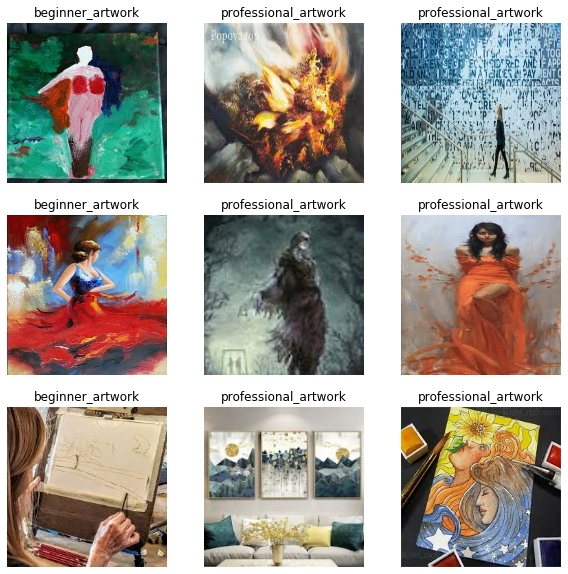

In [6]:
# Visualizing the first 9 images of the training set

class_names = train_data.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# Caching and prefetching the data for better performance

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Implementing image augmentation layer to reduce overfitting

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

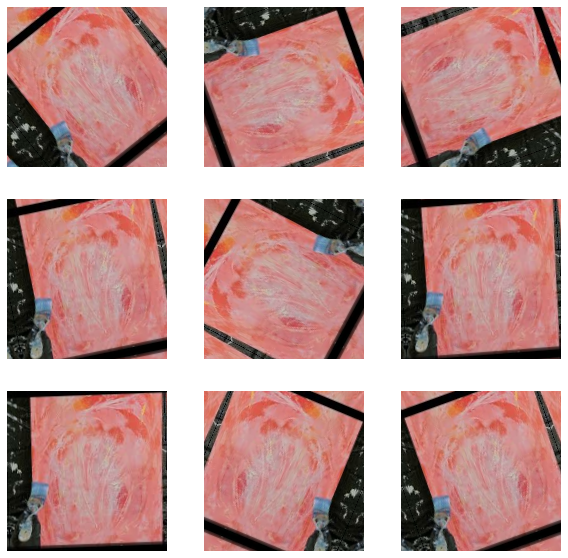

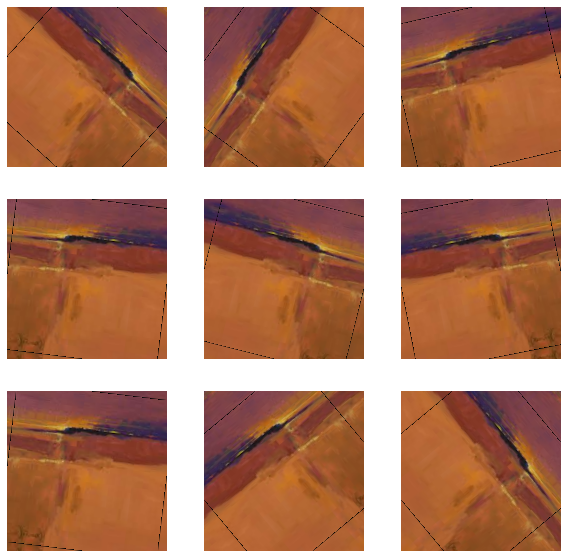

In [11]:
# Viewing the augmented data

for image, _ in train_data.take(2):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# Getting the preprocessing function for the ResNet50V2 model in order to preprocess the data so that it can be inputted to the ResNet50 model
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [13]:
# Creating the base model from the pre-trained model ResNet50V2

IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
)

In [14]:
# Freezing the model so none of the weights of the base layers are updated during training
base_model.trainable = False

In [15]:
# Viewing the architecture of the base model
base_model.summary()

1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 10, 10, 1024) 525312      conv4_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 10, 10, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_out (Add)          (None, 10, 10, 1024) 0           conv4_block1_0_conv[0][0]        
                                                                 conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_preact_bn (BatchNo (None, 10, 10, 1024) 4096        conv4_block1_out[0][0]           
______________________________________________________________________________________

In [16]:
# Feature extraction which converts each image to a 5x5x2048 block of features
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 2048)


In [17]:
# Converting the 5x5x2048 feature blocks to a vector of size 2048
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [18]:
# Adding a dense layer in order to get a prediction, 0 or 1
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [19]:
# Creating a model by chaining together all the above steps
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# Compiling the model before training
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [22]:
# Training the model

initial_epochs = 10
loss0, accuracy0= model.evaluate(validation_data)

8/8 [==============================] - 2s 310ms/step - loss: 60.1950 - accuracy: 0.5440


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 60.20
initial accuracy: 0.54


In [24]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

Epoch 1/10
40/40 [==============================] - 18s 459ms/step - loss: 43.7008 - accuracy: 0.5358 - val_loss: 30.7600 - val_accuracy: 0.5040
Epoch 2/10
40/40 [==============================] - 18s 441ms/step - loss: 36.2353 - accuracy: 0.5533 - val_loss: 22.9917 - val_accuracy: 0.5280
Epoch 3/10
40/40 [==============================] - 17s 437ms/step - loss: 37.9707 - accuracy: 0.5103 - val_loss: 18.6498 - val_accuracy: 0.5360
Epoch 4/10
40/40 [==============================] - 18s 444ms/step - loss: 36.8104 - accuracy: 0.5040 - val_loss: 18.7356 - val_accuracy: 0.5040
Epoch 5/10
40/40 [==============================] - 18s 450ms/step - loss: 31.0992 - accuracy: 0.5310 - val_loss: 15.9016 - val_accuracy: 0.5520
Epoch 6/10
40/40 [==============================] - 19s 482ms/step - loss: 31.8959 - accuracy: 0.5326 - val_loss: 16.6237 - val_accuracy: 0.5520
Epoch 7/10
40/40 [==============================] - 19s 465ms/step - loss: 35.6323 - accuracy: 0.4960 - val_loss: 14.0983 - val_ac

[43.70077133178711, 36.23530960083008, 37.970726013183594, 36.8104248046875, 31.099153518676758, 31.895896911621094, 35.63234329223633, 32.82068634033203, 30.825292587280273, 26.521713256835938]


Text(0.5, 1.0, 'Training and Validation Accuracy')

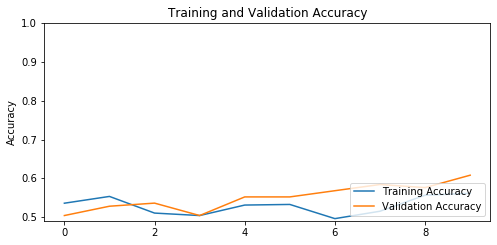

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

Text(0.5, 0, 'epoch')

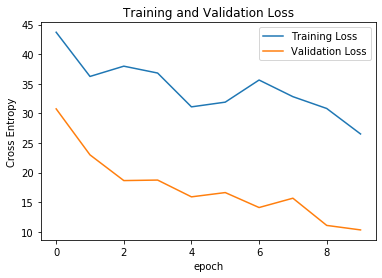

In [37]:

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')